In [ ]:
from functools import reduce
import os
import re
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import neural_network

In [3]:
root_dir = 'data'
data_dir = os.path.join(root_dir, 'ml-1m/')
data_dir_20ml = os.path.join(root_dir, 'ml-20m/')

In [4]:
movie_df = pd.read_csv(os.path.join(data_dir, 'movies.dat'),
                       sep = '::',
                       names = ['mid', 'm_name', 'm_genre'],
                       engine = 'python',
                       encoding = 'latin-1')

In [48]:
display(movie_df.head())

,mid,m_name,m_genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
mid = 10
display(movie_df[movie_df.mid == mid])

,mid,m_name,m_genre
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [7]:
name = 'Machine'
movie_df[movie_df.m_name.str.contains(name)]

,mid,m_name,m_genre
1409,1433,"Machine, The (1994)",Comedy|Horror


In [8]:
rating_df = pd.read_csv(os.path.join(data_dir, 'ratings.dat'),
                        sep = '::',
                        names = ['uid', 'mid', 'rating', 'timestamp'],
                        parse_dates = ['timestamp'],
                        infer_datetime_format = True,
                        engine = 'python')

/var/folders/fx/39y8j8751j37c9vmjzj_2ftm0000gn/T/ipykernel_16406/3514801607.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  rating_df = pd.read_csv(os.path.join(data_dir, 'ratings.dat'),
/var/folders/fx/39y8j8751j37c9vmjzj_2ftm0000gn/T/ipykernel_16406/3514801607.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rating_df = pd.read_csv(os.path.join(data_dir, 'ratings.dat'),


In [9]:
rating_df.head()

,uid,mid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [10]:
users_df = pd.read_csv(os.path.join(data_dir, 'users.dat'),
                       sep = '::',
                       names = ['uid', 'gender', 'age', 'occupation', 'zip'],
                       engine = 'python')

display(users_df.head())

,uid,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [11]:
users_df['zip'] = users_df['zip'].apply(lambda x : x[:2])
display(users_df['zip'].head())

0    48
1    70
2    55
3    02
4    55
Name: zip, dtype: object

In [12]:
tags_scores = pd.read_csv(os.path.join(data_dir_20ml, 'genome-scores.csv.gz'),
                          skiprows = 1,
                          names = ['mid', 'tid', 'relevance'])

display(tags_scores.head(10))

,mid,tid,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675
5,1,6,0.21700
6,1,7,0.06700
7,1,8,0.26275
8,1,9,0.26200
9,1,10,0.03200


In [13]:
tags_scores['relevance'].describe()

count    1.170977e+07
mean     1.164833e-01
std      1.542463e-01
min      2.500000e-04
25%      2.425000e-02
50%      5.650000e-02
75%      1.415000e-01
max      1.000000e+00
Name: relevance, dtype: float64

In [14]:
targs_names = pd.read_csv(os.path.join(data_dir_20ml, 'genome-tags.csv'),
                          skiprows = 1,
                          names = ['tid', 't_name'])

display(targs_names.head(10))

,tid,t_name
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
5,6,1950s
6,7,1960s
7,8,1970s
8,9,1980s
9,10,19th century


In [15]:
tags_scores = tags_scores.loc[tags_scores['mid'].isin(rating_df['mid'].unique())]
tags_scores.mid.nunique()

3470

In [16]:
tags_scores_high = tags_scores.loc[tags_scores['relevance'] > 0.9]

In [17]:
tags_high_names_movies = pd.merge(tags_scores_high, targs_names, how = 'inner', on = 'tid')
tags_high_names_movies = pd.merge(tags_high_names_movies, movie_df, how = 'inner', on = 'mid')

display(tags_high_names_movies.head())

,mid,tid,relevance,t_name,m_name,m_genre
0,1,63,0.93325,animated,Toy Story (1995),Animation|Children's|Comedy
1,1,64,0.98575,animation,Toy Story (1995),Animation|Children's|Comedy
2,1,186,0.95650,cartoon,Toy Story (1995),Animation|Children's|Comedy
3,1,203,0.92625,childhood,Toy Story (1995),Animation|Children's|Comedy
4,1,204,0.96425,children,Toy Story (1995),Animation|Children's|Comedy


In [18]:
tags = 'scary'
tags_high_names_movies[tags_high_names_movies.t_name.str.contains(tags)].sort_values(by = ['relevance'], ascending = False)

,mid,tid,relevance,t_name,m_name,m_genre
11087,2710,882,0.96700,scary,"Blair Witch Project, The (1999)",Horror
5671,1342,882,0.96625,scary,Candyman (1992),Horror
5698,1347,882,0.96550,scary,"Nightmare on Elm Street, A (1984)",Horror
15530,3892,882,0.96475,scary,Anatomy (Anatomie) (2000),Horror
8025,1997,882,0.96200,scary,"Exorcist, The (1973)",Horror
10380,2550,882,0.95625,scary,"Haunting, The (1963)",Horror|Thriller
5714,1350,882,0.94675,scary,"Omen, The (1976)",Horror
11542,2841,882,0.94650,scary,Stir of Echoes (1999),Thriller
7872,1974,882,0.94625,scary,Friday the 13th (1980),Horror
5891,1387,882,0.94250,scary,Jaws (1975),Action|Horror


In [19]:
tags_high_names_movies.tid.nunique()

968

In [20]:
tags_scores_high_dum = pd.get_dummies(tags_scores_high, columns = ['tid'])
tags_scores_high_dum = tags_scores_high_dum.reset_index() * 1

tags_scores_high_dum.head()

,index,mid,relevance,tid_1,tid_2,tid_3,tid_5,tid_6,tid_7,tid_9,...,tid_1119,tid_1120,tid_1121,tid_1122,tid_1123,tid_1124,tid_1125,tid_1126,tid_1127,tid_1128
0,62,1,0.93325,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,1,0.98575,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,185,1,0.95650,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,202,1,0.92625,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,203,1,0.96425,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
tags_per_movie = tags_scores_high_dum.groupby('mid').sum()
tags_per_movie.head()

,index,relevance,tid_1,tid_2,tid_3,tid_5,tid_6,tid_7,tid_9,tid_10,...,tid_1119,tid_1120,tid_1121,tid_1122,tid_1123,tid_1124,tid_1125,tid_1126,tid_1127,tid_1128
mid,,,,,,,,,,,,,,,,,,,,,
1,7430,15.29225,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10684,6.65400,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9019,2.85825,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4499,0.97675,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,30741,5.62725,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Histogram of Movies per tag')

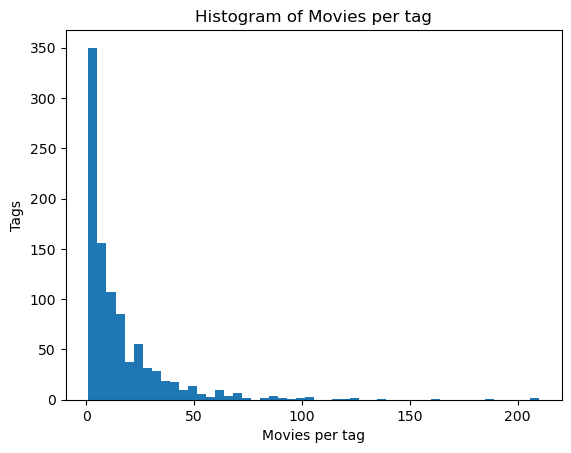

In [37]:
tags_scores_high.groupby(['tid']).count().plot(kind = 'hist', column = 'mid', bins = 50, legend = False)
plt.ylabel('Tags')
plt.xlabel('Movies per tag')
plt.title('Histogram of Movies per tag')

In [61]:
th = tags_scores_high.groupby(['tid']).count()

In [71]:
th.head()

,mid,relevance
tid,,
1,16,16
2,17,17
3,21,21
5,19,19
6,2,2


In [89]:
th.mid.max()

210

In [87]:
targs_names.loc[targs_names.tid == th.mid.idxmax(), 't_name']

229    comedy
Name: t_name, dtype: object

In [93]:
tags_scores_high.groupby(['mid']).count().head()

,tid,relevance
mid,,
1,16,16
2,7,7
3,3,3
4,1,1
5,6,6


<Axes: ylabel='Frequency'>

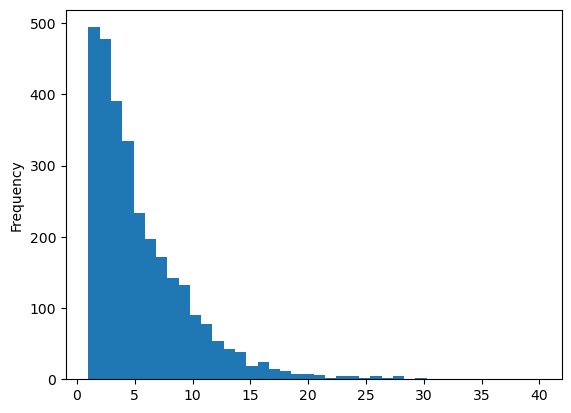

In [102]:
mh = tags_scores_high.groupby(['mid']).count()
mh.plot(kind = 'hist', bins = 40, column = 'tid', legend = False)

In [119]:
movie_df.loc[movie_df['mid'] == mh.tid.idxmax(), 'm_name'].to_string()

'2502    Matrix, The (1999)'

In [117]:
mh.tid.max()

40